<a href="https://colab.research.google.com/github/FabioRovai/protein-structure-into-sound/blob/main/protein_structure_into_sound_thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#**Protein Structure into Sound (PSS)** 
*Notebook in collaboration with Ford Combs*
#####<br/><br/>
This is a tutorial/implementation of of a novel technique to transform protein sequence into sounds.
This implementation aims to be an useful tool to attribuite sounds quality to every specific protein ID.
Here is the code that uses geometrical transformaions to generates this sinusoid IDs.

In [ ]:
%matplotlib inline

import itertools
import IPython
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import os 
import pandas as pd
import random
import re
import requests 
import seaborn as sns
import shutil 
import soundfile as sf
import sys
import warnings
import zipfile

from contextlib import suppress
from __future__ import generators
from IPython.display import clear_output 
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull
from scipy.io import wavfile

warnings.filterwarnings("ignore")

#@markdown ###**Download a list of PDB files from the dunbrack lab.**
#@markdown #####<br/><br/>
#@markdown ##### The following to code blocks allow for downloading a list of PDB files from Dr. Dunbrack Lab website.


# Download PDB file
!wget  https://raw.githubusercontent.com/FabioRovai/test7/main/PDB.txt -O PDB.txt --quiet

# Read PDB file with Pandas
pdb=pd.read_csv ('PDB.txt', delim_whitespace=True, header=0).sort_values(by=['resolution'])
pdb.head(10)

,IDs,length,Exptl.,resolution,R-factor,FreeRvalue
2285,3NIRA,46,XRAY,0.48,0.13,1.00
4026,5D8VA,83,XRAY,0.48,0.07,0.08
4449,5NW3A,54,XRAY,0.59,0.14,0.15
520,1UCSA,64,XRAY,0.62,0.14,0.15
2725,3X2MA,180,XRAY,0.64,0.12,0.13
1360,2VB1A,129,XRAY,0.65,0.08,0.10
532,1US0A,316,XRAY,0.66,0.09,0.10
4964,6E6OA,40,XRAY,0.70,0.17,0.18
5567,6S2MA,133,XRAY,0.72,0.10,0.11
427,1R6JA,82,XRAY,0.73,0.07,0.09


In [ ]:
#@title  Choose your PDB file directly from RCSB PDB

# Define protein ID 
full_protein_ID ="1QOWB"#@param {type:"string"} 

#Fix blank spaces
full_protein_ID=re.sub(r"\t", '',full_protein_ID) 
full_protein_ID=re.sub(r" ", '',full_protein_ID) 

#Search Protein ID on list above 
protein_ID = pdb.IDs.loc[pdb.iloc[:,0].str.contains(full_protein_ID)].iloc[0][:-1]
#full_protein_ID ='' # assign variable if not using a protein from the list above 
#PDB.IDs.iloc[100][:-1] # quick fix selecting proteins by index

# Define url and download data
data = requests.get('https://files.rcsb.org/download/{}.pdb'.format(protein_ID.lower())).text

# Split data into array using newline as delimiter
text = data.split("\n") 

# Gather the coordinates for each c-alpha atom
ca_coordinates = []

for line in text:
  # Matches lines beginning with 'ATOM'
  if 'ATOM' == line[0:4] or 'HETATOM' == line[0:7]:
    # Matches lines with c-alpha coordinates, altLoc A or ' ', and chain A
    # If using the dunbrack list the final == statement should be line[21] == protein_ID[4] (the fifth character)
    if line[13:15] == 'CA' and line[16] in ['A',' '] and line[21] == 'A': 
      # Extract x, y, and z coordinates and 
      # add to coordinates list
      x = float(line[30:38])      
      y = float(line[38:46])     
      z = float(line[46:54])
      ca_coordinates.append([x,y,z])

# Save coordinates as array
ca_coordinates = np.asarray(ca_coordinates)
print ('Coordinates for each c-alpha atom of',protein_ID,'have been successfully extracted.')

Coordinates for each c-alpha atom of 1QOW have been successfully extracted.


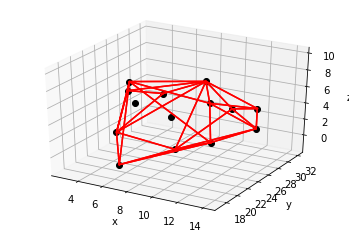

In [ ]:
#@title Calculate Convex hull
# convex hull (Graham scan by x-coordinate) and diameter of a set of points
# David Eppstein, UC Irvine, 7 Mar 2002
def orientation(p,q,r):
    '''Return positive if p-q-r are clockwise, neg if ccw, zero if colinear.'''
    return (q[1]-p[1])*(r[0]-p[0]) - (q[0]-p[0])*(r[1]-p[1])
def hulls(Points):
    '''Graham scan to find upper and lower convex hulls of a set of 2d points.'''
    U = []
    L = []
    #Points.sort()
    for p in Points:
        while len(U) > 1 and orientation(U[-2],U[-1],p) <= 0: U.pop()
        while len(L) > 1 and orientation(L[-2],L[-1],p) >= 0: L.pop()
        U.append(p)
        L.append(p)
    return U,L

def rotatingCalipers(Points):
    '''Given a list of 2d points, finds all ways of sandwiching the points
between two parallel lines that touch one point each, and yields the sequence
of pairs of points touched by each pair of lines.'''
    U,L = hulls(Points)


    i = 0
    j = len(L) - 1
    while i < len(U) - 1 or j > 0:
        yield U[i],L[j]
        # if all the way through one side of hull, advance the other side
        if i == len(U) - 1: j -= 1
        elif j == 0: i += 1
        # still points left on both lists, compare slopes of next hull edges
        # being careful to avoid divide-by-zero in slope calculation
        elif (U[i+1][1]-U[i][1])*(L[j][0]-L[j-1][0]) > \
                (L[j][1]-L[j-1][1])*(U[i+1][0]-U[i][0]):
            i += 1
        else: j -= 1
def diameter(Points):
    '''Given a list of 2d points, returns the pair that's farthest apart.'''
    diam,pair = max([((p[0]-q[0])**2 + (p[1]-q[1])**2, (p,q))
                     for p,q in rotatingCalipers(Points)])
  

    return pair

# 8 points defining the cube corners    
pts = ca_coordinates
hull = ConvexHull(pts)
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")




# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")

# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "r-")

# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))
foo=hull.simplices.tolist()
foo=pts[s]
baz = list(itertools.chain(*foo))

plt.show()

In [ ]:
#@title Calculate Max Width or farthest distance from the center (experimental)



def incremental_farthest_search(points, k):
  with suppress(IndexError):
    remaining_points = points[:]
    solution_set = []
    mean=int(np.mean(baz))
    
    solution_set.append(remaining_points.pop(\
                                             (mean - 0)))
    
    for _ in range(k-1):
        distances = [distance(p, solution_set[0]) for p in remaining_points]
        for i, p in enumerate(remaining_points):
            for j, s in enumerate(solution_set):
                distances[i] = min(distances[i], distance(p, s))
        solution_set.append(remaining_points.pop(distances.index(max(distances))))
    return solution_set
def distance(A, B):
    return abs(A - B)

max_width=0

try:
    bar=incremental_farthest_search(baz,2)
    max_width = np.linalg.norm(bar[0] - bar[1])
except TypeError:
  print('max width cannot be calculates, 0 value assigned')
else:
  print(max_width) 


24.906


Convex Hull Volume: 466.3711871333333
Farthest Distance 2D: 15.962673773525538
Farthest Distance 3D (widest set of points): 24.906
Centroid: [ 8.20371429 24.80285714  3.70892857]
Points in Positive X: 9
Points in Negative X: 5
Points in Positive Y: 4
Points in Negative Y: 10
Points in Positive Z: 4
Points in Negative Z: 10


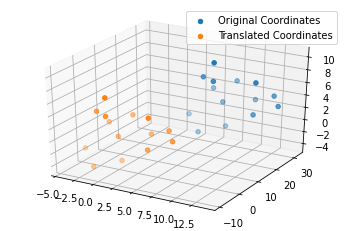

In [ ]:
#@title  Calculate Volume of Convex Hull, Farthest Distance using Rotating Calipers and Centroid and Calculate number of positive and negative points on each axis. 

# Calculate Volume of Convex Hull and Centroid
hull_volume=ConvexHull(ca_coordinates).volume
print("Convex Hull Volume:",hull_volume)

# Calculate Max Distance using rotating caliper
max_points = list(diameter(ca_coordinates))
max_distance = np.linalg.norm(max_points[0] - max_points[1])
print("Farthest Distance 2D:",max_distance)
print("Farthest Distance 3D (widest set of points):",max_width)
centroid = np.sum(ca_coordinates,axis=0)/len(ca_coordinates)
print("Centroid:",centroid)

# Translate structure to be centered on centroid
closest_dist = np.linalg.norm(ca_coordinates[0]-centroid)
closest_point = 0
for i in range(len(ca_coordinates)):
  p = ca_coordinates[i]
  if np.linalg.norm(p-centroid) < closest_dist:
    closest_dist = np.linalg.norm(p-centroid)
    closest_point = i
translated_ca_coors = []
for i in range(len(ca_coordinates)):
  p = ca_coordinates[i]
  translated_ca_coors.append(p-ca_coordinates[closest_point])
translated_ca_coors = np.asarray(translated_ca_coors)

# Calculate number of positive and negative points on each axis 
pos_neg_xyz = [0,0,0,0,0,0]
for i in range(len(translated_ca_coors)):
  p = translated_ca_coors[i]
  if p[0] > 0:
    pos_neg_xyz[0]+=1
  else:
    pos_neg_xyz[1]+=1
  if p[1] > 0:
    pos_neg_xyz[2]+=1
  else:
    pos_neg_xyz[3]+=1
  if p[1] > 0:
    pos_neg_xyz[4]+=1
  else:
    pos_neg_xyz[5]+=1

print("Points in Positive X:",pos_neg_xyz[0])
print("Points in Negative X:",pos_neg_xyz[1])
print("Points in Positive Y:",pos_neg_xyz[2])
print("Points in Negative Y:",pos_neg_xyz[3])
print("Points in Positive Z:",pos_neg_xyz[4])
print("Points in Negative Z:",pos_neg_xyz[5])

#Plot
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(ca_coordinates[:,0],ca_coordinates[:,1],ca_coordinates[:,2],label='Original Coordinates')
ax.scatter(translated_ca_coors[:,0],translated_ca_coors[:,1],translated_ca_coors[:,2],label='Translated Coordinates')
plt.legend()
plt.show()

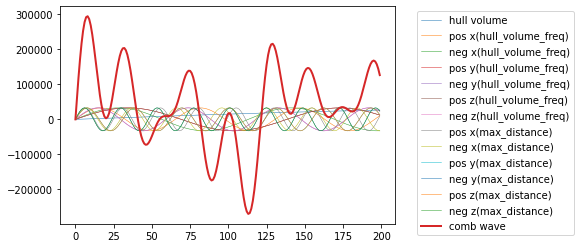

In [ ]:
#@title  Add characteristics to a Combinational Wave
samplerate = 44100

# Volume wave
hull_volume_freq = hull_volume/1000 # scaling down a bit
t = np.linspace(0., 10., samplerate)/(len(ca_coordinates)/100)
amplitude = np.iinfo(np.int16).max
volume_signal = amplitude * np.sin(2. * np.pi * hull_volume_freq * t)

# Waveshaping against hull_volume_freq 

# Pos X wave
pos_x = amplitude * np.sin(2. * np.pi * (hull_volume_freq+pos_neg_xyz[0]) * t)
# Neg X wave
neg_x = amplitude * np.sin(2. * np.pi * (hull_volume_freq+pos_neg_xyz[1]) * t)
# Pos Y wave
pos_y = amplitude * np.sin(2. * np.pi * (hull_volume_freq+pos_neg_xyz[2]) * t)
# Neg X wave
neg_y = amplitude * np.sin(2. * np.pi * (hull_volume_freq+pos_neg_xyz[3]) * t)
# Pos Z wave
pos_z = amplitude * np.sin(2. * np.pi * (hull_volume_freq+pos_neg_xyz[4]) * t)
# Neg Z wave
neg_z = amplitude * np.sin(2. * np.pi * (hull_volume_freq+pos_neg_xyz[5]) * t)

# Waveshaping against max_distance

# Pos X wave
pos_ax = amplitude * np.sin(2. * np.pi * (max_distance+pos_neg_xyz[0]) * t)
# Neg X wave
neg_ax = amplitude * np.sin(2. * np.pi * (max_distance+pos_neg_xyz[1]) * t)
# Pos Y wave
pos_ay = amplitude * np.sin(2. * np.pi * (max_distance+pos_neg_xyz[2]) * t)
# Neg X wave
neg_ay = amplitude * np.sin(2. * np.pi * (max_distance+pos_neg_xyz[3]) * t)
# Pos Z wave
pos_az = amplitude * np.sin(2. * np.pi * (max_distance+pos_neg_xyz[4]) * t)
# Neg Z wave
neg_az = amplitude * np.sin(2. * np.pi * (max_distance+pos_neg_xyz[5]) * t)

# Waveshaping against max_width (if experimental part works)
if 'solution_set' in globals():
  pos_axa = amplitude * np.sin(2. * np.pi * (max_width+pos_neg_xyz[0]) * t)
  neg_axa = amplitude * np.sin(2. * np.pi * (max_width+pos_neg_xyz[1]) * t)
  pos_aya = amplitude * np.sin(2. * np.pi * (max_width+pos_neg_xyz[2]) * t)
  neg_aya = amplitude * np.sin(2. * np.pi * (max_width+pos_neg_xyz[3]) * t)
  pos_aza = amplitude * np.sin(2. * np.pi * (max_width+pos_neg_xyz[4]) * t)
  neg_aza = amplitude * np.sin(2. * np.pi * (max_width+pos_neg_xyz[5]) * t)
else:
  pos_axa = 0
  neg_axa = 0
  pos_aya = 0
  neg_aya = 0
  pos_aza = 0
  neg_aza = 0



# Combination wave
data = volume_signal + pos_x + neg_x + pos_y + neg_y + pos_z + neg_z + pos_ax + neg_ax + pos_ay + neg_ay + pos_az + neg_az + pos_axa + neg_axa + pos_aya + neg_aya + pos_aza + neg_aza 

# Plot
n = 200


plt.plot(volume_signal[0:n],label='hull volume',linewidth=0.5)
plt.plot(pos_x[0:n],label='pos x(hull_volume_freq)',linewidth=0.5)
plt.plot(neg_x[0:n],label='neg x(hull_volume_freq)',linewidth=0.5)
plt.plot(pos_y[0:n],label='pos y(hull_volume_freq)',linewidth=0.5)
plt.plot(neg_y[0:n],label='neg y(hull_volume_freq)',linewidth=0.5)
plt.plot(pos_z[0:n],label='pos z(hull_volume_freq)',linewidth=0.5)
plt.plot(neg_z[0:n],label='neg z(hull_volume_freq)',linewidth=0.5)

plt.plot(pos_ax[0:n],label='pos x(max_distance)',linewidth=0.5)
plt.plot(neg_ax[0:n],label='neg x(max_distance)',linewidth=0.5)
plt.plot(pos_ay[0:n],label='pos y(max_distance)',linewidth=0.5)
plt.plot(neg_ay[0:n],label='neg y(max_distance)',linewidth=0.5)
plt.plot(pos_az[0:n],label='pos z(max_distance)',linewidth=0.5)
plt.plot(neg_az[0:n],label='neg z(max_distance)',linewidth=0.5)

if 'solution_set' in globals():
  plt.plot(pos_axa[0:n],label='pos x(max_width)',linewidth=0.5)
  plt.plot(neg_axa[0:n],label='neg x(max_width)',linewidth=0.5)
  plt.plot(pos_aya[0:n],label='pos y(max_width)',linewidth=0.5)
  plt.plot(neg_aya[0:n],label='neg y(max_width)',linewidth=0.5)
  plt.plot(pos_aza[0:n],label='pos z(max_width)',linewidth=0.5)
  plt.plot(neg_aza[0:n],label='neg z(max_width)',linewidth=0.5)
else: 
  pass

plt.plot(data[0:n],label='comb wave',linewidth=2)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [ ]:
#@title  Rescale, store and retrive

# Rescale data because adding waves increases the amplitude beyond the limit
data += -(np.min(data))
data /= np.max(data) / (np.iinfo(np.int16).max - np.iinfo(np.int16).min)
data += np.iinfo(np.int16).min
wavfile.write('test_wave.wav', 44100, data.astype(np.int16))

# Store and retrive signal
bigData=pd.DataFrame(data,columns=[protein_ID]) #protein_ID
retrive=bigData.iloc[:,0].to_numpy()
wavfile.write('retrive.wav', 44100, data.astype(np.int16))
IPython.display.Audio("test_wave.wav")

#IPython.display.Audio('retrive.wav')

In [ ]:
#@title Generating Datasets for protein quality retrival 
b=bigData.values.tolist()
pdb=pdb.T
pdb.rename(columns=pdb.iloc[0], inplace = True)

pdb.at[0, str(full_protein_ID)] = b
pdb.at[1, str(full_protein_ID)] = hull_volume_freq
pdb.at[2, str(full_protein_ID)] = max_distance
pdb.at[4, str(full_protein_ID)] = max_width

pdb=pdb.T
pdb=pdb.reset_index(drop=True)
pdb.rename(columns={ pdb.columns[6]: "sounds",pdb.columns[7]: "volume",pdb.columns[8]: "max_distance",pdb.columns[9]: "max_width" }, inplace = True)
pdb.replace(0, np.nan, inplace=True)

#print ()
displayPdb=pdb.set_index('IDs')

print(displayPdb.loc[full_protein_ID],bigData.T)

length                                                         20
Exptl.                                                       XRAY
resolution                                                   1.06
R-factor                                                     0.14
FreeRvalue                                                      1
sounds          [[115.59583201262285], [4808.246923128841], [9...
volume                                                   0.466371
max_distance                                              15.9627
max_width                                                  24.906
Name: 1QOWB, dtype: object            0            1           2      ...       44097        44098        44099
1QOW  115.595832  4808.246923  9292.15287  ...  4685.44093  4466.458418  4143.752109

[1 rows x 44100 columns]


[]

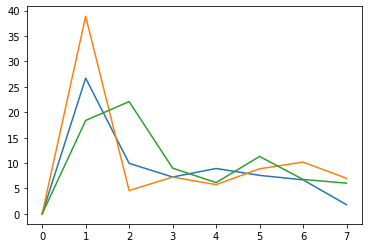

In [ ]:
#@title Further work section, proof of concept with RFFT

#center coordinates

x = ca_coordinates[:,0]-np.mean(ca_coordinates[:,0])
y = ca_coordinates[:,1]-np.mean(ca_coordinates[:,1])
z = ca_coordinates[:,2]-np.mean(ca_coordinates[:,2])

# X axis rfft
x_rfft = np.fft.rfft(x)
x_freq = []
x_amp = []
x_phase = []
for i in range(len(x_rfft)):
  x_freq.append(i)
  x_amp.append(np.sqrt(x_rfft[i].real**2+x_rfft[i].imag**2))
  x_phase.append(np.arctan2(x_rfft[i].imag,x_rfft[i].real))

# Y axis rfft
y_rfft = np.fft.rfft(y)
y_freq = []
y_amp = []
y_phase = []
for i in range(len(y_rfft)):
  y_freq.append(i)
  y_amp.append(np.sqrt(y_rfft[i].real**2+y_rfft[i].imag**2))
  y_phase.append(np.arctan2(y_rfft[i].imag,y_rfft[i].real))

# Z axis rfft

z_rfft = np.fft.rfft(z)
z_freq = []
z_amp = []
z_phase = []
for i in range(len(z_rfft)):
  z_freq.append(i)
  z_amp.append(np.sqrt(z_rfft[i].real**2+z_rfft[i].imag**2))
  z_phase.append(np.arctan2(z_rfft[i].imag,z_rfft[i].real))

#Plot

n = len(x_freq)
plt.plot(x_freq[:n],x_amp[:n],label='x')
plt.plot(y_freq[:n],y_amp[:n],label='y')
plt.plot(z_freq[:n],z_amp[:n],label='z')
plt.plot()

In [ ]:
#@title Take the top five highest frequencies for each axis' fft
x_highest_freqs = [x for _, x in sorted(zip(x_amp, x_freq), reverse=True, key=lambda pair: pair[0])][:10] 
y_highest_freqs = [x for _, x in sorted(zip(y_amp, y_freq), reverse=True, key=lambda pair: pair[0])][:10] 
z_highest_freqs = [x for _, x in sorted(zip(z_amp, z_freq), reverse=True, key=lambda pair: pair[0])][:10]

print(x_highest_freqs)
print(y_highest_freqs)
print(z_highest_freqs)

[1, 2, 4, 5, 3, 6, 7, 0]
[1, 6, 5, 3, 7, 4, 2, 0]
[2, 1, 5, 3, 6, 4, 7, 0]


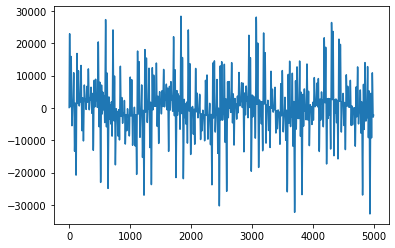

In [ ]:
#@title Add characteristics to wave (12 tone approach)
samplerate = 44100
base_frequency = 100
t = np.linspace(0., 1., samplerate)
amplitude = np.iinfo(np.int16).max
# base_signal = amplitude * np.sin(2. * np.pi * base_frequency * t)
freqs_seen = set()
x_signal = []
for i in range(len(x_highest_freqs)):
  f = x_highest_freqs[i]
  x_signal += list(amplitude * np.sin(2. * np.pi * (base_frequency*(2**(1/12))*f) * t)) # scaling factor np.exp(-0.02*i)
y_signal = []
for i in range(len(y_highest_freqs)):
  f = y_highest_freqs[i]
  y_signal += list(amplitude * np.sin(2. * np.pi * (base_frequency*(2**(1/12))*f) * t))
z_signal = []
for i in range(len(z_highest_freqs)):
  f = z_highest_freqs[i]
  z_signal += list(amplitude * np.sin(2. * np.pi * (base_frequency*(2**(1/12))*f) * t))
x_signal = np.asarray(x_signal)
y_signal = np.asarray(y_signal)
z_signal = np.asarray(z_signal)

n=5000
#plt.plot(x_signal[:n])
#plt.plot(y_signal[:n])
#plt.plot(z_signal[:n])
plt.plot(data[:n])

data = x_signal + y_signal + z_signal
data += -(np.min(data))
data /= np.max(data) / (np.iinfo(np.int16).max - np.iinfo(np.int16).min)
data += np.iinfo(np.int16).min
wavfile.write('twelve-tone_comb_wave.wav', 44100, data.astype(np.int16))
IPython.display.Audio("twelve-tone_comb_wave.wav")

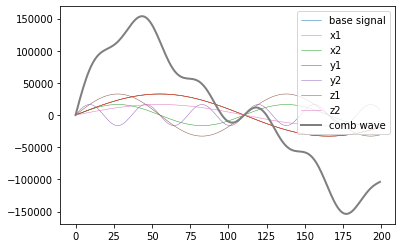

In [ ]:
#@title Add characteristics to wave (highest frequency approach)
samplerate = 44100
base_frequency = 10
t = np.linspace(0., 20., samplerate)
amplitude = np.iinfo(np.int16).max
volume_signal = amplitude * np.sin(2. * np.pi * base_frequency * t)
# Pos X FFT waves
x1 = amplitude * np.sin(2. * np.pi * (base_frequency*x_highest_freqs[0]) * t)
x2 = 0.5*amplitude * np.sin(2. * np.pi * (base_frequency*x_highest_freqs[1]) * t)
# x3 = 0.85*amplitude * np.sin(2. * np.pi * (base_frequency*x_highest_freqs[2]) * t)
# x4 = 0.8*amplitude * np.sin(2. * np.pi * (base_frequency*x_highest_freqs[3]) * t)
# x5 = 0.75*amplitude * np.sin(2. * np.pi * (base_frequency*x_highest_freqs[4]) * t)
y1 = amplitude * np.sin(2. * np.pi * (base_frequency*y_highest_freqs[0]) * t)
y2 = 0.5*amplitude * np.sin(2. * np.pi * (base_frequency*y_highest_freqs[1]) * t)
z1 = amplitude * np.sin(2. * np.pi * (base_frequency*z_highest_freqs[0]) * t)
z2 = 0.5*amplitude * np.sin(2. * np.pi * (base_frequency*z_highest_freqs[1]) * t)
# Combination wave
data = volume_signal + x1 + x2 + y1 + y2 + z1 + z2

n = 200
plt.plot(volume_signal[0:n],label='base signal',linewidth=0.5)
plt.plot(x1[0:n],label='x1',linewidth=0.5)
plt.plot(x2[0:n],label='x2',linewidth=0.5)
plt.plot(y1[0:n],label='y1',linewidth=0.5)
plt.plot(y2[0:n],label='y2',linewidth=0.5)
plt.plot(z1[0:n],label='z1',linewidth=0.5)
plt.plot(z2[0:n],label='z2',linewidth=0.5)
plt.plot(data[0:n],label='comb wave',linewidth=2)
plt.legend()
plt.show()


data += -(np.min(data))
data /= np.max(data) / (np.iinfo(np.int16).max - np.iinfo(np.int16).min)
data += np.iinfo(np.int16).min
wavfile.write('test_wave.wav', 44100, data.astype(np.int16))



IPython.display.Audio("test_wave.wav")